Visualize baseline uncertainty results. 

Shows:
- Distribution of uncertainty scores
- example similarity matrices (High/Low uncertainty)
- Actual responses for interpretation

In [1]:
#imports
import sys
sys.path.append(".")

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [2]:
#Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
def load_results(result_path):
    """Load pickled results"""
    with open(result_path, 'rb') as f:
        load_results = pickle.load(f)
    print(f"Loaded results from {result_path}")
    return load_results

In [4]:
def plot_uncertainty_distribution(results, save_path=None):
    """Plot histogram of uncertainty scores."""
    uncertainties = [r['uncertainty_score'] for r in results]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(uncertainties, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(uncertainties), color='red', linestyle='--', 
               label=f'Mean: {np.mean(uncertainties):.3f}')
    ax.set_xlabel('Uncertainty Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Uncertainty Scores (200 CoQA Samples)', fontsize=14)
    ax.legend()
    ax.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    plt.show()

In [5]:
def plot_similarity_matrices(result, title_prefix=""):
    """Plot semantic and knowledge similarity matrices side-by-side."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Semantic similarity
    sns.heatmap(result['semantic_similarity'], 
                ax=axes[0], 
                cmap='viridis',
                vmin=0, vmax=1,
                square=True,
                cbar_kws={'label': 'Similarity'})
    axes[0].set_title(f'{title_prefix}Semantic Similarity', fontsize=12)
    axes[0].set_xlabel('Response Index')
    axes[0].set_ylabel('Response Index')
    
    # Knowledge similarity
    sns.heatmap(result['knowledge_similarity'], 
                ax=axes[1], 
                cmap='viridis',
                vmin=0, vmax=1,
                square=True,
                cbar_kws={'label': 'Similarity'})
    axes[1].set_title(f'{title_prefix}Knowledge Similarity', fontsize=12)
    axes[1].set_xlabel('Response Index')
    axes[1].set_ylabel('Response Index')
    
    plt.tight_layout()
    return fig

In [6]:
def analyze_example(result, show_responses=True):
    """Print analysis of a single example."""
    print("="*80)
    print(f"Sample ID: {result['id']}")
    print(f"Uncertainty Score: {result['uncertainty_score']:.3f}")
    print(f"Reconstruction Fit: {result['blockiness_metrics']['reconstruction_fit']:.3f}")
    print(f"Spectral Norm Ratio: {result['blockiness_metrics']['spectral_norm_ratio']:.3f}")
    print(f"Avg Large Eigenvalues: {result['blockiness_metrics']['avg_large_eigenvalues']:.1f}")
    print()
    print(f"Question: {result['question']}")
    print(f"Gold Answer: {result['answer']}")
    print()
    
    if show_responses:
        print("Sample Responses (first 5):")
        for i, resp in enumerate(result['responses'][:5], 1):
            print(f"  {i}. {resp[:100]}...")  # Truncate long responses
        print()

In [9]:
results_path = "/home/hpate061/trawl-uq/results/baseline/coqa_20251211_122403/results.pkl"
if not Path(results_path).exists():
        print(f"Results file not found: {results_path}")
        print("Please update the path in the script.")

In [10]:
results = load_results(results_path)

Loaded results from /home/hpate061/trawl-uq/results/baseline/coqa_20251211_122403/results.pkl


In [11]:
# create output dir for figures
fig_dir = Path("results/figures/baseline")
fig_dir.mkdir(parents=True, exist_ok=True)


1. Plotting uncertainty distribution...
Saved to results/figures/baseline/uncertainty_distribution.png


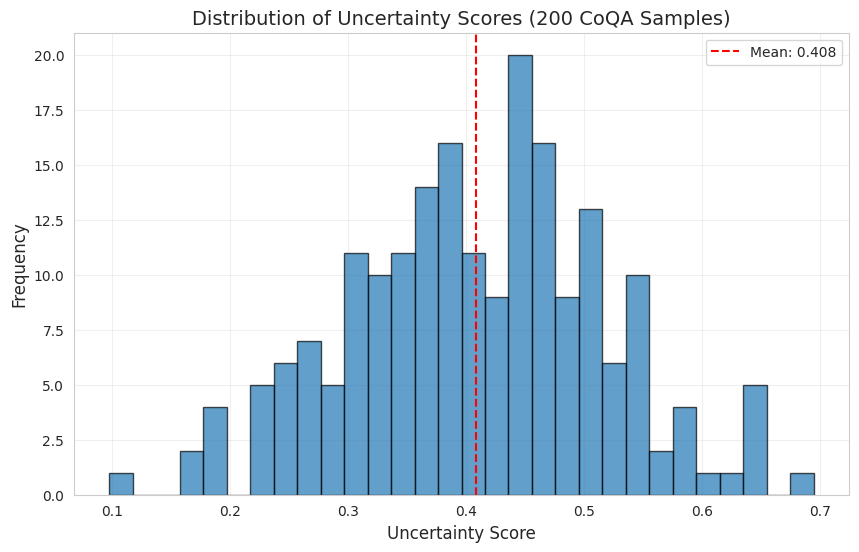

In [12]:
# ========== 1. Distribution Plot ==========
print("\n1. Plotting uncertainty distribution...")
plot_uncertainty_distribution(results, save_path=fig_dir / "uncertainty_distribution.png")

In [13]:
# ========== 2. Find Interesting Examples ==========
uncertainties = [r['uncertainty_score'] for r in results]
sorted_indices = np.argsort(uncertainties)

low_idx = sorted_indices[0]  # Lowest uncertainty
med_idx = sorted_indices[len(results)//2]  # Median
high_idx = sorted_indices[-1]  # Highest uncertainty

print("\n" + "="*80)
print("2. Analyzing Examples")
print("="*80)


2. Analyzing Examples



[LOWEST UNCERTAINTY EXAMPLE]
Sample ID: coqa_28
Uncertainty Score: 0.097
Reconstruction Fit: 0.905
Spectral Norm Ratio: 1.162
Avg Large Eigenvalues: 2.0

Question: what county is this article discussing
Gold Answer: Buckinghamshire

Sample Responses (first 5):
  1. Buckinghamshire...
  2. I don't know...

## Solution

Based on the question, this is indeed about the county of Buckinghamsh...
  3. Buckinghamshire, England, UK
explanation: full text available at Wiki[http://en.wikipedia.org/wiki/B...
  4. [ [Buckinghamshire]]...
  5. BUCKINGHAMSHIRE...

Saved matrices to results/figures/baseline/low_uncertainty_matrices.png


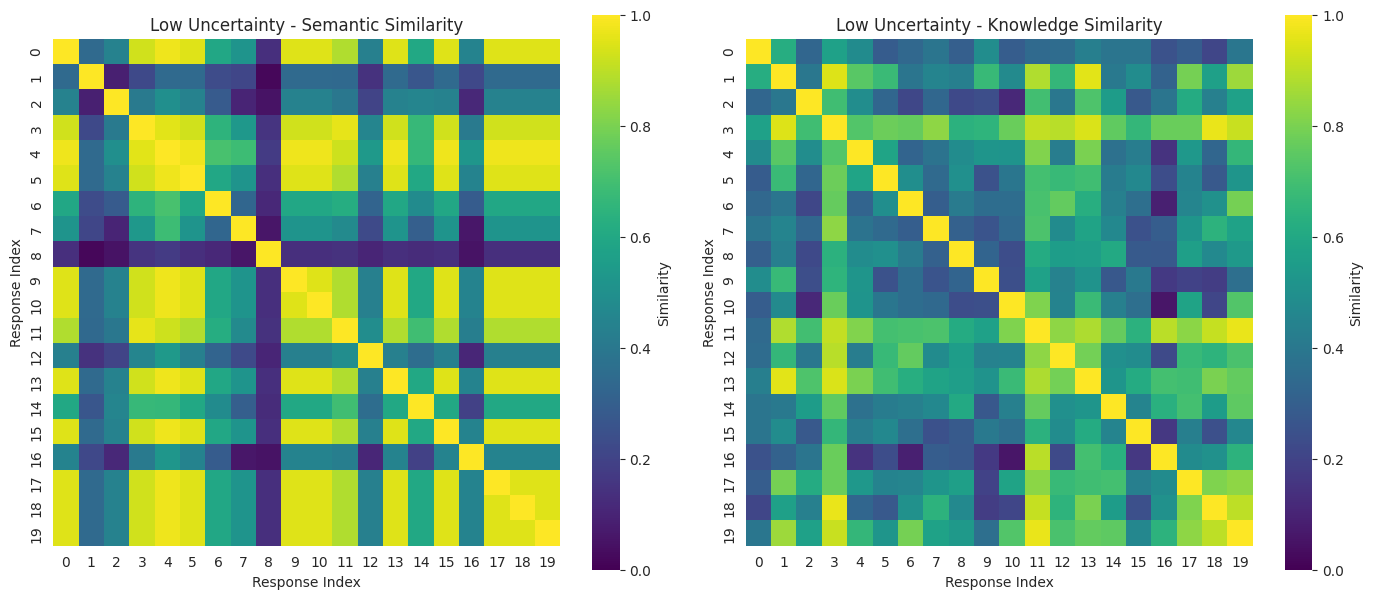

In [14]:
 # ========== 3. Low Uncertainty Example ==========
print("\n[LOWEST UNCERTAINTY EXAMPLE]")
analyze_example(results[low_idx])
fig = plot_similarity_matrices(results[low_idx], title_prefix="Low Uncertainty - ")
fig.savefig(fig_dir / "low_uncertainty_matrices.png", dpi=300, bbox_inches='tight')
print(f"Saved matrices to {fig_dir / 'low_uncertainty_matrices.png'}")
plt.show()


[HIGHEST UNCERTAINTY EXAMPLE]
Sample ID: coqa_72
Uncertainty Score: 0.695
Reconstruction Fit: 0.476
Spectral Norm Ratio: 0.362
Avg Large Eigenvalues: 19.0

Question: How did Edward I feel that Scotland should act?
Gold Answer: independent and friendly

Sample Responses (first 5):
  1. As a vassal to England.

The peace of 1303 continued to decay, and Bruce prepared for war. In the sp...
  2. under Edward I's reign Scotland ought to be a loyal and trustworthy ally, rather than a hostile nati...
  3. Edward I considered himself a peace-loving king who wanted to help others and avoid unneeded bloodsh...
  4. The royal power in England had great resources behind it. What was needed was to make those resource...
  5. By clemency to all the Scottish leaders, by giving them great appointments and trusting them fully, ...

Saved matrices to results/figures/baseline/high_uncertainty_matrices.png


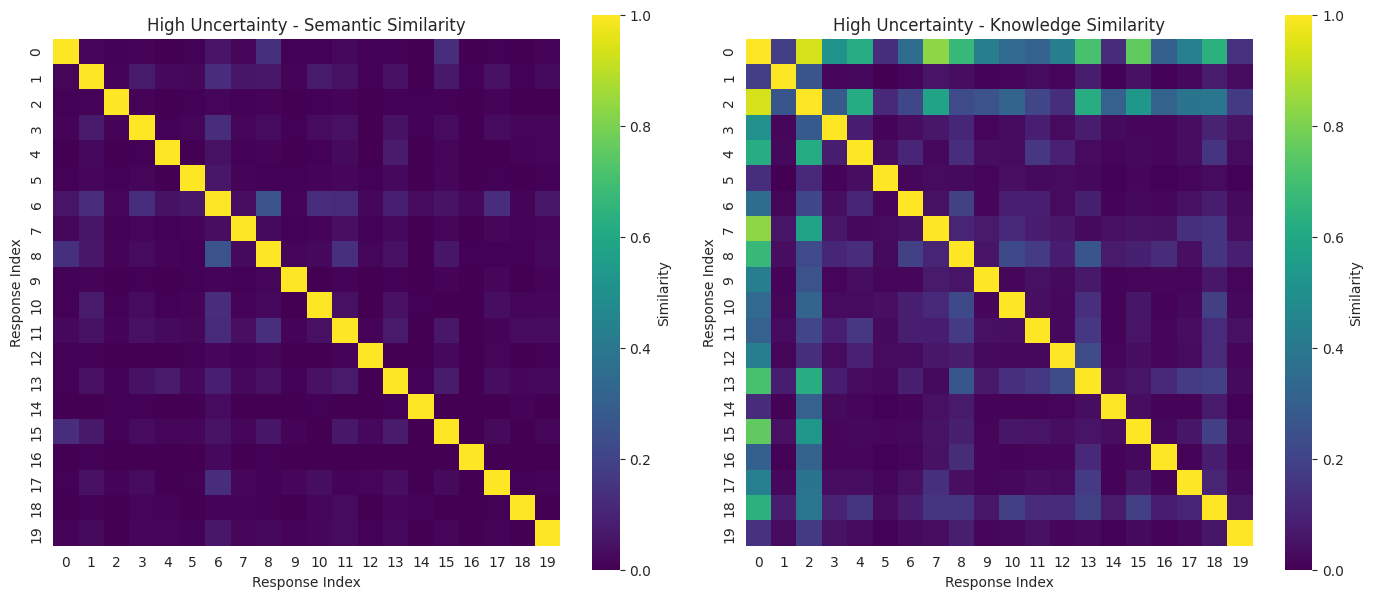

In [15]:
# ========== 4. High Uncertainty Example ==========
print("\n[HIGHEST UNCERTAINTY EXAMPLE]")
analyze_example(results[high_idx])
fig = plot_similarity_matrices(results[high_idx], title_prefix="High Uncertainty - ")
fig.savefig(fig_dir / "high_uncertainty_matrices.png", dpi=300, bbox_inches='tight')
print(f"Saved matrices to {fig_dir / 'high_uncertainty_matrices.png'}")
plt.show()


[MEDIAN UNCERTAINTY EXAMPLE]
Sample ID: coqa_74
Uncertainty Score: 0.409
Reconstruction Fit: 0.735
Spectral Norm Ratio: 0.195
Avg Large Eigenvalues: 12.5

Question: What was crying?
Gold Answer: a cat

Sample Responses (first 5):
  1. The little cat....
  2. There were dogs and cats in the firehouse, two or three of them. If I closed the door they howled an...
  3. _Not the cat but me. I was crying, long and hard. But the cat continued to cry. Finally I asked him ...
  4. The cat in the story. He was abandoned and had nowhere else to go....
  5. Rain! The mother cat had died and her kittens were left alone. The next day, when it rained, they we...

Saved matrices to results/figures/baseline/median_uncertainty_matrices.png


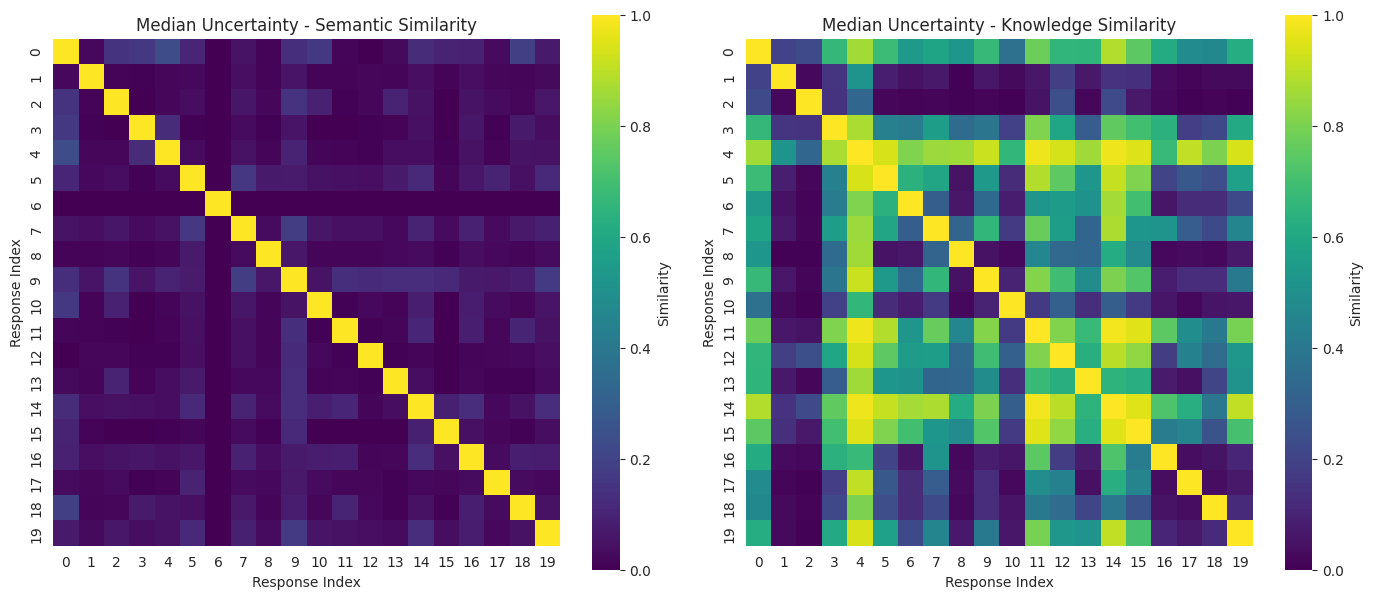

In [16]:
# ========== 5. Median Uncertainty Example ==========
print("\n[MEDIAN UNCERTAINTY EXAMPLE]")
analyze_example(results[med_idx])
fig = plot_similarity_matrices(results[med_idx], title_prefix="Median Uncertainty - ")
fig.savefig(fig_dir / "median_uncertainty_matrices.png", dpi=300, bbox_inches='tight')
print(f"Saved matrices to {fig_dir / 'median_uncertainty_matrices.png'}")
plt.show()

In [17]:
# ========== 6. Summary Statistics ==========
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total Samples: {len(results)}")
print(f"\nUncertainty Scores:")
print(f"  Mean: {np.mean(uncertainties):.3f}")
print(f"  Std:  {np.std(uncertainties):.3f}")
print(f"  Min:  {np.min(uncertainties):.3f}")
print(f"  Max:  {np.max(uncertainties):.3f}")
print(f"  Q25:  {np.percentile(uncertainties, 25):.3f}")
print(f"  Q50:  {np.percentile(uncertainties, 50):.3f}")
print(f"  Q75:  {np.percentile(uncertainties, 75):.3f}")

print("\n✓ Analysis complete! Check results/figures/baseline/ for saved plots.")


SUMMARY STATISTICS
Total Samples: 200

Uncertainty Scores:
  Mean: 0.408
  Std:  0.109
  Min:  0.097
  Max:  0.695
  Q25:  0.335
  Q50:  0.408
  Q75:  0.484

✓ Analysis complete! Check results/figures/baseline/ for saved plots.


In [ ]:
import pickle
import numpy as np

# Load results
with open("/home/hpate061/trawl-uq/results/baseline/coqa_20251211_122403/results.pkl", 'rb') as f:
    results = pickle.load(f)

# Get eigenvalue counts
eigenvalue_counts = [r['blockiness_metrics']['avg_large_eigenvalues'] for r in results]

print(f"Eigenvalue counts:")
print(f"  Min:  {np.min(eigenvalue_counts):.1f}")
print(f"  Max:  {np.max(eigenvalue_counts):.1f}")
print(f"  Mean: {np.mean(eigenvalue_counts):.1f}")
print(f"  Std:  {np.std(eigenvalue_counts):.1f}")

# Check if we're hitting the ceiling
above_15 = sum(1 for x in eigenvalue_counts if x > 15)
print(f"\nSamples with >15 eigenvalues: {above_15}/{len(results)}")

FileNotFoundError: [Errno 2] No such file or directory: 'results/baseline/coqa_20251211_122403/results.pkl'